In [1]:
! export PYTHONPATH=$PYTHONPATH:/data/chodera/wangyq/bronx/

In [3]:
import sys
sys.path.append('/data/chodera/wangyq/bronx/')

In [14]:
import bronx
import torch
import dgl
import pyro
from matplotlib import pyplot as plt

In [8]:
model = torch.load("/data/chodera/wangyq/node_classification/best.pt", map_location=torch.device('cpu'))

In [9]:
model

NodeClassificationBronxModel(
  (fc_in): Sequential(
    (0): Linear(in_features=1433, out_features=42, bias=False)
  )
  (fc_out): Sequential(
    (0): ELU(alpha=1.0)
    (1): Dropout(p=0.5303411489006438, inplace=False)
    (2): Linear(in_features=42, out_features=7, bias=False)
  )
  (activation): ELU(alpha=1.0)
  (layer0): BronxLayer(
    (fc_mu): Linear(in_features=42, out_features=147, bias=False)
    (fc_log_sigma): Linear(in_features=42, out_features=147, bias=False)
    (fc_k): Linear(in_features=42, out_features=147, bias=False)
    (fc_mu_prior): Linear(in_features=42, out_features=21, bias=False)
    (fc_log_sigma_prior): Linear(in_features=42, out_features=21, bias=False)
    (activation): ELU(alpha=1.0)
    (linear_diffusion): LinearDiffusion(
      (odefunc): ODEFunc()
    )
    (norm): LayerNorm((42,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.6939372020133809, inplace=False)
  )
  (consistency_regularizer): ConsistencyRegularizer()
)

In [29]:
def graph_forward(self, g, h, y=None, mask=None):
    h = self.fc_in(h)
    for idx in range(self.depth):
        h = getattr(self, f"layer{idx}")(g, h)
    return g

In [30]:
from run import get_graph
g = get_graph("CoraGraphDataset")

In [31]:
g = graph_forward(model, g, g.ndata["feat"])

In [34]:
param_store = pyro.get_param_store()

In [38]:
predictive = pyro.infer.Predictive(
    model,
    guide=model.guide,
    num_samples=4,
    parallel=True,
)

results = predictive(g, g.ndata["feat"])

In [41]:
results["e0"].shape

torch.Size([4, 10556, 21, 1])

In [45]:
from matplotlib import pyplot as plt
import seaborn as sns
e = results["e0"].flatten().detach().numpy()


In [87]:
h = g.ndata["feat"]
h = model.fc_in(h)
h = model.layer0.norm(h)
mu_prior, log_sigma_prior = model.layer0.fc_mu_prior(h), model.layer0.fc_log_sigma_prior(h)
src, dst = g.edges()
mu_prior = mu_prior[..., dst, :]
log_sigma_prior = log_sigma_prior[..., dst, :]
mu_prior, log_sigma_prior = mu_prior.unsqueeze(-1), log_sigma_prior.unsqueeze(-1)
sigma_prior = log_sigma_prior.exp() * model.layer0.sigma_factor

In [89]:
from math import log
mu_posterior, log_sigma_posterior, k_posterior = model.layer0.fc_mu(h), model.layer0.fc_log_sigma(h), model.layer0.fc_k(h)
mu_posterior = mu_posterior.reshape(*mu_posterior.shape[:-1], model.layer0.num_heads, -1)
log_sigma_posterior = log_sigma_posterior.reshape(
    *log_sigma_posterior.shape[:-1], model.layer0.num_heads, -1
)
k_posterior = k_posterior.reshape(*k_posterior.shape[:-1], model.layer0.num_heads, -1)

g.ndata["mu_posterior"], g.ndata["log_sigma_posterior"], g.ndata["k_posterior"] = mu_posterior, log_sigma_posterior, k_posterior
g.apply_edges(dgl.function.u_dot_v("k_posterior", "mu_posterior", "mu_posterior"))
g.apply_edges(
    dgl.function.u_dot_v("k_posterior", "log_sigma_posterior", "log_sigma_posterior")
)

mu_posterior = g.edata["mu_posterior"]
log_sigma_posterior = g.edata["log_sigma_posterior"] 
sigma_posterior = log_sigma_posterior.exp() * model.layer0.sigma_factor

(0.0, 1.0)

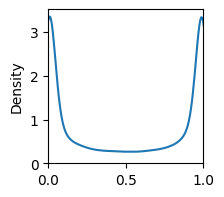

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
e_posterior = torch.distributions.Normal(mu_posterior, sigma_posterior).sample().flatten().sigmoid()
sns.kdeplot(e_posterior)
ax.set_xlim(0, 1)